# 3. Análisis de tópicos con LDA (Latent Dirichlet Allocation)

## 3.1 Motivación

El __análisis de tópicos__ permite descubrir, a partir de los propios textos, el conjunto de tópicos que estos abordan. Se trata de un análisis automatizado, que podría ser difícil de llevar a cabo manualmente, debido a la cantidad de textos.

Uno de los algoritmos más comunes para analizar tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_ (Artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view)

__¿Qué hace LDA?__

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## 3.2 ¿Cómo hacer un análisis de tópicos en Python?

En este tutorial, tomaremos un dataset de noticias de prensa en español del mes de febrero 2021 y utilizaremos LDA para descubrir cuáles son los tópicos de las noticias.

### 3.2.1 Cargar el dataset de noticias

In [1]:
import pandas

# leer el archivo CSV
archivo = "./data/catrillanca.csv"
corpus = pandas.read_csv(archivo)

In [2]:
corpus.head(5)

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date
0,0,243393.0,chile,horas24,https://www.24horas.cl/nacional/instituto-naci...,Instituto Nacional de Derechos Humanos amplía ...,El Instituto Nacional de Derechos Humanos (IND...,2019-06-22
1,1,5163425.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/268476-pa...,Padre de Catrillanca solicita presencia de Bac...,Hasta el Palacio de la Moneda llegó Marcelo Ca...,2019-07-17
2,2,13829736.0,chile,emol,https://www.emol.com/noticias/Nacional/2019/03...,"Adolescente que acompañaba a Catrillanca: ""Hab...",SANTIAGO.- A casi cuatro meses de la muerte de...,2019-03-10
3,3,5439896.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/245535-ca...,Cartas enviadas a familia de Camilo Catrillanc...,"Hace unos días Marcelo Catrillanca, padre de C...",2018-12-30
4,4,5442943.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/245302-ca...,Caso Catrillanca: Comuneros mapuche se toman l...,"Durante la mañana de este jueves, un grupo de ...",2018-12-27


- Son 2.931 noticias en total.

In [3]:
len(corpus)

2931

- Creamos una lista de noticias a partir del corpus

In [4]:
noticias = corpus.text.values.tolist()

In [5]:
noticias[501]

'El 14 de noviembre de 2018, en la comuna de Ercilla en la Región de La Araucanía, un grupo de integrantes del Comando Jungla del GOPE de Carabineros asesinó al comunero mapuche de 24 años, Camilo Catrillanca. El crimen se realizó en el contexto de un operativo por un supuesto delito de robo que minutos antes habìa tenido lugar, identificando erradamente los policías a Catrillanca como uno de los participantes en el atraco, disparándole entonces mientras este se encontraba sobre el tractor en el que trabajaba. El joven iba entonces acompañado por su amigo de 15 años de iniciales M.A.P.C., quien fue agredido y torturado por los uniformados. Desde entonces ha pasado un año y el caso se encuentra en manos de la Justicia, la que este próximo 30 de noviembre llevará a cabo la audiencia de juicio oral en contra de los carabineros acusados por el crimen de Camilo. Federico Aguirre, jefe regional de La Araucanía del Instituto Nacional de Derechos Humanos (INDH), querellante en este caso, decla

### 3.2.2  Instalación de librerias

- Instalamos en nuestra máquina la libreria "pyLDAvis" que permite visualizar los resultados del análisis de tópicos 

Note bene: los comandos "pip install .." solo se hacen una vez para descargar las librerias en su computador.

In [6]:
!pip install pyLDAvis

- Utilizaremos spacy para procesar textos en español (no es útil instalar la libreria con "pip instal..." ya que ya lo hicimos en notebook anterior)

In [7]:
!python -m spacy download es_core_news_sm

[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [8]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

- Utilizaremos Gensim (para el análisis de tópicos) y pyLDAvis (para visualizar los tópicos)

In [9]:
!pip install gensim

In [10]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

### 3.2.3 Preprocesamiento de las noticias

Procesaremos todas las noticias para representarlas como una lista de:
- sustantivos (NOUN)
- y conceptos claves (NOUN-de-NOUN) y (NOUN-ADJ)
- entidades (PER) y (ORG)

- Agregamos patrones para buscar conceptos claves

In [11]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

- Definemos una función para preprocesar una noticia y transformarla en una lista de "palabras" relevantes.

In [12]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [13]:
noticias[0]

'El Instituto Nacional de Derechos Humanos (INDH) solicitó al Juzgado de Garantía de Collipulli ampliar la querella por la muerte de Camilo Catrillanca, fallecido el 14 de noviembre de 2018 durante un operativo policial en la región de la Araucanía. De acuerdo lo que consigna el INDH en su sitio web, ya han presentado cuatro acciones judiciales en el caso. Se trata de una querella por el homicidio de Catrillanca, una por obstrucción a la investigación, una por el homicidio frustrado del adolescente de 15 años que acompañaba a Camilo Catrillanca la jornada de su muerte, además de las querellas por torturas que habría sufrido este último tras ser detenido. La organización también plantea que ha prestado apoyo y acompañamiento a la familia de Camilo Catrillanca en las distintas aristas tras la muerte del joven dirigente mapuche. Además, indican que han participado de procesos como la observación ocular de la autopsia del cuerpo de Catrillanca, la reconstitución de la escena de los eventos

In [14]:
text_to_list(noticias[0])

['querella',
 'muerte',
 'noviembre',
 'operativo',
 'región',
 'acuerdo',
 'INDH',
 'sitio',
 'acciones',
 'caso',
 'querella',
 'homicidio',
 'obstrucción',
 'investigación',
 'homicidio',
 'adolescente',
 'años',
 'jornada',
 'muerte',
 'querellas',
 'torturas',
 'organización',
 'apoyo',
 'acompañamiento',
 'familia',
 'aristas',
 'muerte',
 'joven',
 'dirigente',
 'procesos',
 'observación',
 'autopsia',
 'cuerpo',
 'reconstitución',
 'escena',
 'eventos',
 'toma',
 'declaración',
 'uniformados',
 'operativo',
 'proceso',
 'investigación',
 'caso',
 'reabierto',
 'plazo',
 'semanas',
 'petición',
 'defensa',
 'peritajes',
 'Juzgado de Garantía de Collipulli',
 'Camilo Catrillanca',
 'Camilo Catrillanca',
 'Camilo Catrillanca',
 'operativo policial',
 'sitio web',
 'acciones judiciales',
 'homicidio frustrado',
 'dirigente mapuche',
 'observación ocular',
 'toma de declaración',
 'declaración de uniformados',
 'uniformados involucrados',
 'proceso de investigación',
 'investigación

- Transformamos todas las noticias de nuestro corpus "noticias" aplicando la función "text_to_list". De cierta manera, simplificará el texto guardando solamente las palabras y conceptos importantes.

In [15]:
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


- Veamos cómo se transformó una cierta noticia. La variable "N" representa el rango de la noticia en nuestro corpus.

In [16]:
N=5

In [17]:
print(noticias[N])

Marcelo Catrillanca, padre del comunero mapuche asesinado, se refirió al nuevo video correspondiente a una segunda cámara que estaba en poder de uno de los excarabineros que participó en el operativo del pasado 14 de noviembre donde murió Camilo Catrillanca. "Nosotros siempre dijimos la verdad, que ese video existía. Siguen apareciendo evidencias", sostuvo Catrillanca desde el Congreso. En ese sentido, manifestó que "estaban todos informados, por lo que ellos querían ocultar la verdad". En particular, apuntó a la responsabilidad del general director de Carabineros, Hermes Soto, señalando que él mintió. "Tiene que ser imputado y condenado porque ocultó la verdad que los funcionarios que estaban a su cargo, lo hicieron", sostuvo el padre de Catrillanca. "Creo que el general director de Carabineros debería dar un paso al costado, así como el ministro del Interior, Andrés Chadwick", sostuvo. Agregó, que "nosotros queremos saber quién mató a mi hijo". Marcelo Catrillanca presentó durante es

- Se simplificó en:

In [18]:
print(noticias_procesadas[5])

['padre', 'comunero', 'video', 'cámara', 'poder', 'excarabineros', 'operativo', 'noviembre', 'verdad', 'video', 'evidencias', 'sentido', 'verdad', 'particular', 'responsabilidad', 'general', 'director', 'verdad', 'funcionarios', 'cargo', 'padre', 'director', 'paso', 'costado', 'ministro', 'hijo', 'jornada', 'carta', 'esclarecimiento', 'Marcelo Catrillanca', 'Camilo Catrillanca', 'Hermes Soto', 'Marcelo Catrillanca', 'comunero mapuche', 'video correspondiente', 'esclarecimiento histórico']


### 3.2.4 Preparar los datos de entrada de LDA

los datos de entrada de LDA son: 
- un diccionario (variable 'id2word')
- nuestro dataset preprocesado ('noticias_procesadas')

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario. Por ejemplo con el ID=25 corresponde a la palabra:

In [20]:
id2word[179]

'abuelo'

In [21]:
texts = noticias_procesadas

- Ahora una noticia se vuelve imposible de leer para un humano. Miremos por ejemplo la noticia N.

In [22]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

# View
print(dataset[:N])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)], [(0, 2), (27, 2), (28, 2), (29, 1), (33, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1)], [(0, 1), (7, 5), (11, 1), (12, 1), (26, 1), (28, 4), (29, 1), (65, 1), (69, 2), (70, 2), (73, 3),

### 3.3. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 5 tópicos. 

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

- Guardaremos el modelo en el disco duro

In [24]:
lda_model.save('./output/lda_model_catrillanca_5')

### 3.4. Visualizar los tópicos encontrados

- Se puede imprimir los tópicos con sus principales palabras principales...

In [25]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.007*"arte" + 0.007*"m2" + 0.007*"revuelta" + 0.005*"jugadores" + '
  '0.005*"silencio" + 0.004*"cura" + 0.004*"fútbol" + 0.004*"aislamiento" + '
  '0.004*"amparo" + 0.003*"risa" + 0.003*"misas" + 0.003*"Mariano Puga" + '
  '0.003*"preso político" + 0.003*"artistas" + 0.003*"gallery" + '
  '0.003*"sacerdotes" + 0.003*"zapatismo" + 0.003*"canción" + 0.003*"amigo" + '
  '0.002*"’" + 0.002*"align="aligncenter" + 0.002*"club" + 0.002*"tratos" + '
  '0.002*"pucha" + 0.002*"misa" + 0.002*"creencias" + 0.002*"*" + 0.002*"niño" '
  '+ 0.002*"desigualdad" + 0.002*"estadio" + 0.002*"letra" + 0.002*"chicos" + '
  '0.002*"cancha" + 0.002*"planeta" + 0.002*"caption" + 0.002*"superficie" + '
  '0.002*"Mauricio Hernández Norambuena" + 0.002*"Cecilia Magni" + '
  '0.002*"calidad de preso" + 0.002*"puntajes" + 0.002*"galería" + '
  '0.002*"amistades" + 0.002*"Facultad" + 0.002*"crímenes de odio" + '
  '0.002*"revuelta social" + 0.002*"música" + 0.002*"bienal" + '
  '0.002*"materiales" + 0.002*

- ... o se puede visualizar mejor con la libreria pyLDAvis

Nota bene: el número que identifica los topicos puede cambiar... 

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

C:\Users\marce\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.167863 -0.110588       1        1  39.988432
4      0.174837 -0.136567       2        1  30.442174
1      0.170831  0.254416       3        1  22.899850
2     -0.242430 -0.104298       4        1   4.403301
0     -0.271101  0.097036       5        1   2.266243, topic_info=          Term         Freq        Total Category  logprob  loglift
3183         }  1260.000000  1260.000000  Default  30.0000  30.0000
82    ministro  2462.000000  2462.000000  Default  29.0000  29.0000
2285         $   817.000000   817.000000  Default  28.0000  28.0000
201   gobierno  1921.000000  1921.000000  Default  27.0000  27.0000
264    general  1939.000000  1939.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
5769    chicos    14.667826    15.221829   Topic5  -6.3236   3.7500
883   silencio    37.359111   105.149318   Topic5  -5.3887   2.7522
2115    tratos    17.880082    53.817879   Topic5  -6.1256   2.6851
103      amigo    20.456659   140.662030   Topic5  -5.9909   1.8590
1161      niño    15.183929    43.876913   Topic5  -6.2890   2.7259

[286 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2081      2  0.164168     #
2081      4  0.833466     #
2285      4  0.999864     $
4077      1  0.192264     '
4077      4  0.804012     '
...     ...       ...   ...
257       1  0.396008  zona
257       2  0.603253  zona
3183      4  1.000058     }
3184      4  0.998202   } #
6335      5  0.974843     ’

[367 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

### 3.5. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.62783713547561

Coherence Score:  0.4603564190196405


### 3.6. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

- Queremos encontrar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad). Probaremos con distintos valores de número de tópicos.

In [28]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

- Entrenaremos modelos desde 2 tópicos hasta 15 tópicos con un salto de 2 --> 2, 4, 6, 8, 10, 12, 14

Nota bene: Se puede demorar varios minutos (o incluso varias horas según el tamaño del dataset)

In [29]:
start=2
limit=15
step=2

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8
10
12
14


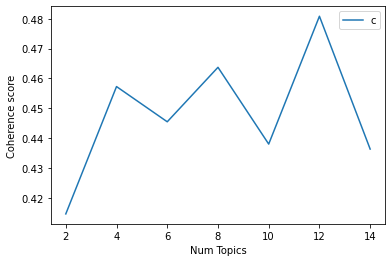

In [31]:

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- ¿Cuál modelo conservar? Miraremos la métrica de coherencia...

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4147
Num Topics = 4  has Coherence Value of 0.4573
Num Topics = 6  has Coherence Value of 0.4455
Num Topics = 8  has Coherence Value of 0.4637
Num Topics = 10  has Coherence Value of 0.438
Num Topics = 12  has Coherence Value of 0.4808
Num Topics = 14  has Coherence Value of 0.4364


In [33]:
# Select the model and print the topics
optimal_model = model_list[4]

- Guardaremos el mejor modelo en un archivo para poder reutilizarlo despues sin volver a entrenar...

In [34]:
archivo='./output/optimal_model_catrillanca_10'

In [35]:
optimal_model.save(archivo)

- En cualquier momento, se puede volver a cargar el model desde el archivo, sin volver a entrenar el modelo...

In [36]:
from gensim.models import LdaModel

optimal_model = LdaModel.load(archivo, mmap='r')

- Visualizemos el modelo de tópicos

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, dataset, id2word)
vis

C:\Users\marce\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.327172  0.009830       1        1  41.300683
5      0.336637  0.075266       2        1  34.181873
4      0.273295 -0.233947       3        1  15.196506
7      0.025347  0.328056       4        1   5.882262
6     -0.108323 -0.056966       5        1   2.067995
8     -0.170066 -0.031159       6        1   0.662525
2     -0.175487 -0.026119       7        1   0.472167
0     -0.170178 -0.022437       8        1   0.113809
1     -0.170465 -0.021835       9        1   0.097130
9     -0.167930 -0.020689      10        1   0.025052, topic_info=                  Term         Freq        Total Category  logprob  loglift
3183                 }  2020.000000  2020.000000  Default  30.0000  30.0000
2285                 $  1309.000000  1309.000000  Default  29.0000  29.0000
82            ministro  2664.000000  2664.000000  Default  28.0000  28.0000
213           personas  1706.000000  1706.000000  Default  27.0000  27.0000
201           gobierno  2306.000000  2306.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
31162  Gustavo Gatica.     0.002370     0.397072  Topic10 -10.5493   3.1706
27411  fines de agosto     0.002369     0.406490  Topic10 -10.5496   3.1469
29445     Ximena Chong     0.002370     0.409772  Topic10 -10.5494   3.1391
2261       motocicleta     0.002370     0.411475  Topic10 -10.5493   3.1350
15499          patente     0.002370     0.497137  Topic10 -10.5493   2.9459

[469 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2081       3  0.998280          #
2285       4  0.999853          $
4077       4  1.000349          '
4080       4  0.996968  //obtener
14080      6  0.977222       2001
...      ...       ...        ...
257        2  0.293256       zona
257        3  0.127407       zona
3183       4  0.999768          }
3184       4  0.999477        } #
764        6  0.987815          ”

[411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 5, 8, 7, 9, 3, 1, 2, 10])

### 8. ¿Cuál es el tópico principal de cada documento?

- Podemos analizar cuál es el tópico principal de cada documento

In [ ]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

- La variable "df_dominant_topic" contiene una columna "Dominant_topic" que indica el tópico principal en cada documento y cuál su porcentaje (variable "Topic_Perc_contrib")

- Añadiremos la columna "media_outlet" para saber de qué medio viene cada noticia

In [ ]:
media_outlet = corpus.filter(['media_outlet'], axis=1)
df_dominant_topic=df_dominant_topic.join(media_outlet)
df_dominant_topic

- Podemos contar cuántos documentos son por tópicos principales:

In [ ]:
from pandasql import sqldf 

In [ ]:
result = sqldf("SELECT Dominant_Topic, count(*) as nb_noticias FROM df_dominant_topic GROUP BY Dominant_Topic ORDER BY count(*) DESC")
result

- ¿Cuál es la noticia más representativa de cada tópcio?

- Tópico 1

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=1.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

- Tópico 2

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=2.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

- Tópico 5

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=5.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 5")
result

- Tópico 6

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=6.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 3")
result

- tópico 7

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=7.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

In [ ]:
noticias[1943]

- tópico 8

In [ ]:
?

__¿Conclusiones?__

- El tópico de "violaciones/democracia/manifestaciones" nunca es el tópico central de la noticia que hablan de Catrillanca. Es un tópico al segundo plano.

- ...

__¿Cómo nombrar los tópicos?__

Del más frecuente al menos frecuente...

6 --> Consecuencias del caso Catrillanca para el gobierno y sus ministros

8 --> Consecuencias judiciales del caso Catrillanca

1 --> Relato del caso Catrillanca

2 --> Noticias que integran un medio con ruido HTML (video, redes sociales)

5 --> Crisis de confianza instituciones Carabiñeros y Fuerzas Armadas



¿Qué medios hablan de crisis de confianza?

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT media_outlet,dominant_topic, count(*) FROM df_dominant_topic GROUP BY media_outlet,dominant_topic ORDER BY media_outlet, count(*) DESC")
result

In [ ]:
data = {'t0':[],'t1':[],'t2':[],'t3':[],'t4':[],'t5':[],'t6':[],'t7':[],'t8':[],'t9':[]}

df_by_media = pd.DataFrame(data)  
  
df_by_media

In [ ]:
 for i, row_list in enumerate(optimal_model[dataset]):
    
    t0=0
    t1=0
    t2=0
    t3=0
    t4=0
    t5=0
    t6=0
    t7=0
    t8=0
    t9=0
    
    for topic in row_list[0]:
        key=topic[0]
        value=topic[1]
        
        if key == 0:
            t0 = value
        if key == 1:
            t1 = value
        if key == 2:
            t2 = value
        if key == 3:
            t3 = value
        if key == 4:
            t4 = value
        if key == 5:
            t5 = value
        if key == 6:
            t6 = value
        if key == 7:
            t7 = value
        if key == 8:
            t8 = value
        if key == 9:
            t9 = value
            
    new_row = {'t0':t0,'t1':t1,'t2':t2,'t3':t3,'t4':t4,'t5':t5,'t6':t6,'t7':t7,'t8':t8,'t9':t9}
    df_by_media = df_by_media.append(new_row, ignore_index=True)

In [ ]:
df_by_media=df_by_media.join(media_outlet)

In [ ]:
df_by_media

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT media_outlet,avg(t0),avg(t1),avg(t2),avg(t3),avg(t4),avg(t5),avg(t6),avg(t7),avg(t8),avg(t9) FROM df_by_media GROUP BY media_outlet ORDER BY media_outlet ASC")
result

In [ ]:
import seaborn as sns
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 16))

result=result.drop(['media_outlet'], axis=1)
sns.heatmap(result, annot=True, cmap="YlGnBu")